# Installing all the neccesary libraries

In [7]:
import subprocess
import sys

# Function to check if a library is installed
def check_and_install(package):
    try:
        __import__(package)
        print(f"{package} is already installed.")
    except ImportError:
        print(f"{package} not found. Installing...")
        result = subprocess.run([sys.executable, "-m", "pip", "install", package], 
                                stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        if result.returncode == 0:
            print(f"{package} installed successfully.")
        else:
            print(f"Error installing {package}: {result.stderr}")

# List of required libraries
required_libraries = [
    'tensorflow',
    'keras',
    'numpy',
    'matplotlib',
    'pyngrok',
    'flask',
    'pillow',
]

# Install required libraries if not already installed
for library in required_libraries:
    check_and_install(library)

# After installation, confirm everything is installed
for library in required_libraries:
    subprocess.run([sys.executable, "-m", "pip", "show", library], 
                   stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)


print("<<<<<<<<<<<<<<<<<<<<<<<<<<<<                    Done Installing                     >>>>>>>>>>>>>>")

tensorflow is already installed.
keras is already installed.
numpy is already installed.
matplotlib is already installed.
pyngrok is already installed.
flask is already installed.
pillow not found. Installing...
pillow installed successfully.
<<<<<Done Installing>>>>


In [8]:

# Import all necessary modules
import os
import shutil
import random
import time
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from flask import Flask, request, jsonify
from pyngrok import ngrok
from IPython.display import display, HTML


print("<<<<<<<<<<<<<<<<<<<<<<<<                   All required libraries installed and imports completed - DONE       >>>>>>>>>>>>>>>>>>>>")

All required libraries installed and imports completed - DONE


# Setting up variables for Testing Training Data

In [9]:
# clean dir
#shutil.rmtree('/kaggle/working')

# create folder for datasets if doesnt exists
if not os.path.exists("/kaggle/working/apple/good"):
    os.makedirs("/kaggle/working/apple/good")
if not os.path.exists("/kaggle/working/apple/bad"):
    os.makedirs("/kaggle/working/apple/bad")
if not os.path.exists("/kaggle/working/apple/mixed"):
    os.makedirs("/kaggle/working/apple/mixed")

# move relevant dataset to a folder
move_paths = [
    ['/kaggle/input/fruit-quality-classification/Good Quality_Fruits/Apple_Good/', '/kaggle/working/apple/good'],
    ['/kaggle/input/fruit-quality-classification/Bad Quality_Fruits/Apple_Bad/', '/kaggle/working/apple/bad'],
    ['/kaggle/input/fruit-quality-classification/Mixed Qualit_Fruits/Apple/', '/kaggle/working/apple/mixed']
] 

for move_path in move_paths:
    src_path = move_path[0]
    trg_path = move_path[1]
    for src_file in Path(src_path).glob('*.*'):
        shutil.copy(src_file, trg_path)


print("<<<<<<<<<<<<<<<<<<<<<<<<<<<                 Done Importing Images from the dataset                     >>>>>>>>>>>>>>>>>>>>>>")

done Importing Images from the dataset


In [10]:
# dataset count
good_bananas = next(os.walk('/kaggle/working/apple/good'))[2]
print('Good Apple: ', len(good_bananas))

bad_bananas = next(os.walk('/kaggle/working/apple/bad'))[2]
print('Bad Apple: ', len(bad_bananas))

mix_bananas = next(os.walk('/kaggle/working/apple/mixed'))[2]
print('Mixed Apple: ', len(mix_bananas))

Good Apple:  1149
Bad Apple:  1141
Mixed Apple:  113


# 1. Implement CNN

In [13]:
# Split training and testing datasets

import random

def split_files(src_dir, train_file_count, test_dir, train_dir):
    # Get a list of all files in the source 
    print(src_dir)
    files = os.listdir(src_dir)
    print(len(files))
    # Shuffle the list of files
    random.shuffle(files)
    print(len(files))
    # Move the first `train_file_count` files to the train directory
    for i in range(train_file_count):
        file = files[i]
        # print(file)
        src_path = os.path.join(src_dir, file)
        dst_path = os.path.join(train_dir, file)
        os.rename(src_path, dst_path)

    # Move the remaining files to the test directory
    for file in files[train_file_count:]:
        src_path = os.path.join(src_dir, file)
        dst_path = os.path.join(test_dir, file)
        os.rename(src_path, dst_path)


print("<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<                Done with the spliting of files                >>>>>>>>>>>>>>>>>>>>>>>>>>")

done with the spliting of files


In [14]:
if not os.path.exists("/kaggle/working/test/good"):
    os.makedirs("/kaggle/working/test/good")
if not os.path.exists("/kaggle/working/train/good"):
    os.makedirs("/kaggle/working/train/good")
if not os.path.exists("/kaggle/working/test/bad"):
    os.makedirs("/kaggle/working/test/bad")
if not os.path.exists("/kaggle/working/train/bad"):
    os.makedirs("/kaggle/working/train/bad")
if not os.path.exists("/kaggle/working/test/mixed"):
    os.makedirs("/kaggle/working/test/mixed")
if not os.path.exists("/kaggle/working/train/mixed"):
    os.makedirs("/kaggle/working/train/mixed")

# Set the source directory and the destination directories
src_dir_good = '/kaggle/working/apple/good'
test_dir_good = '/kaggle/working/test/good'
train_dir_good = '/kaggle/working/train/good'

src_dir_bad = '/kaggle/working/apple/bad'
test_dir_bad = '/kaggle/working/test/bad'
train_dir_bad = '/kaggle/working/train/bad'

src_dir_mix = '/kaggle/working/apple/mixed'
test_dir_mix = '/kaggle/working/test/mixed'
train_dir_mix = '/kaggle/working/train/mixed'

split_files(src_dir_good, 1000, test_dir_good, train_dir_good)
split_files(src_dir_bad, 1000, test_dir_bad, train_dir_bad)

/kaggle/working/apple/good
1149
1149
/kaggle/working/apple/bad
1141
1141


In [15]:
split_files(src_dir_mix, 100, test_dir_mix, train_dir_mix)

/kaggle/working/apple/mixed
113
113


In [16]:
labels = ['good', 'bad','mixed']
# prepare dataset

# from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(rescale=1./255, validation_split = 0.1)
test_datagen = ImageDataGenerator(rescale=1./255) 


train_path = '/kaggle/working/train'
test_path = '/kaggle/working/test'

train_dataset = datagen.flow_from_directory(batch_size=32,
                                                 directory=train_path,
                                                 shuffle=True,
                                                classes=labels,
                                                 target_size=(240,240), 
                                                 subset="training",
                                                 class_mode='categorical')

val_dataset = datagen.flow_from_directory(batch_size=32,
                                                 directory=train_path,
                                                 shuffle=True,
                                                classes=labels,
                                                 target_size=(240,240), 
                                                 subset="validation",
                                                 class_mode='categorical')

Found 1890 images belonging to 3 classes.
Found 210 images belonging to 3 classes.


In [17]:
def print_files(dir_path):
    # Get a list of all files in the directory
    files = os.listdir(dir_path)

    print(f'Found {len(files)} files')
    
    # Print the files
    for file in files:
        print(file)


print('done setting up the function')

done setting up the function


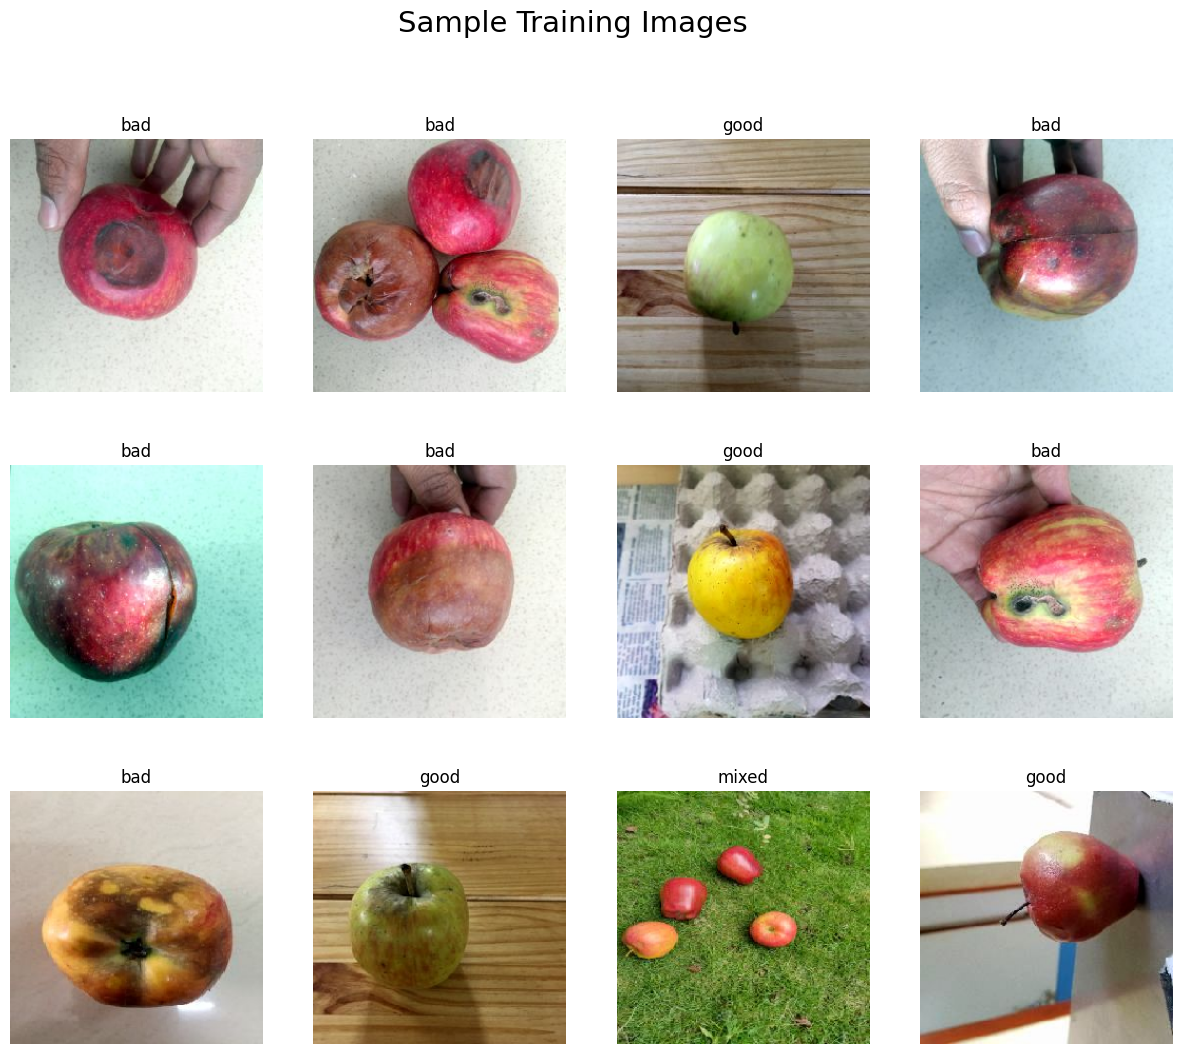

In [18]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(15, 12))
idx = 0

for i in range(3):
    for j in range(4):
        label = labels[np.argmax(train_dataset[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_dataset[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

# plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

In [19]:
# # Create model

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(240,240,3)),  # Explicitly define input shape first
    tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu'),  # No need for input_shape here
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("done with setting up the model")

I0000 00:00:1744382225.537332      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744382225.538097      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


done with setting up the model


In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 238, 238, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 119, 119, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 119, 119, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 117, 117, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 58, 58, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 58, 58, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      12,845,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,946,883 (49.39 MB)

 Trainable params: 12,946,883 (49.39 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:


history = model.fit(
    train_dataset,  # Just pass the generator directly
    steps_per_epoch=len(train_dataset),  # Optional (TF can infer it)
    epochs=20,
    validation_data=val_dataset,
    validation_steps=len(val_dataset)  # Optional
)

print("<<<<<<<<<<<<<<<<<<<<<<<<<<<Done with the training>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1744382238.025647     141 service.cc:148] XLA service 0x7fcbc400d380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744382238.026578     141 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1744382238.026600     141 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1744382238.417596     141 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/60 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.4219 - loss: 3.6675 

I0000 00:00:1744382244.988943     141 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 170ms/step - accuracy: 0.5038 - loss: 1.8732 - val_accuracy: 0.4238 - val_loss: 0.8171
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/20


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.8452 - loss: 0.3825 - val_accuracy: 0.5429 - val_loss: 0.9494
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9413 - loss: 0.1539 - val_accuracy: 0.6476 - val_loss: 0.9987
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9416 - loss: 0.1406 - val_accuracy: 0.6714 - val_loss: 1.4050
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 185us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.9705 - loss: 0.0730 - val_accuracy: 0.5571 - val_loss: 1.9432
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9764 - loss: 0.0532 - val_accuracy: 0.5095 - val_loss: 3.109

# Testing

In [14]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_path,
                                                  batch_size=1,
                                                  target_size=(240,240),
                                                  shuffle = False,
                                                  classes=labels,
                                                  class_mode='categorical')


filenames = test_generator.filenames
nb_samples = len(filenames)

loss, acc = model.evaluate(test_generator,steps = (nb_samples), verbose=1)
print('accuracy test: ',acc)
print('loss test: ',loss)

Found 303 images belonging to 3 classes.
303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9451 - loss: 0.3767
accuracy test:  0.9042904376983643
loss test:  0.5778144598007202


 Done with testing

# Saving the model optinal Part

In [21]:
model.save("/kaggle/working/apple_model.h5")

print("<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<           Model has been locally saved                >>>>>>>>>>>>>>>>>>>>>>>>>>>>>")

Model has been locally saved


# Setting Up the server for API

In [24]:
from flask import Flask, request, jsonify
from werkzeug.utils import secure_filename
from PIL import Image
import numpy as np
import io
import tensorflow as tf
from pyngrok import ngrok

app = Flask(__name__)

# Define class names (should match your training labels order)
CLASS_NAMES = ['good', 'bad', 'mixed']

def preprocess_image(image):
    """Preprocess image to match model's expected input format"""
    # Convert RGBA to RGB if needed
    if image.mode == 'RGBA':
        image = image.convert('RGB')
    image = image.resize((240, 240))
    image_array = np.array(image) / 255.0
    return np.expand_dims(image_array, axis=0)

# Load your trained model (do this ONCE when starting the server)
model = tf.keras.models.load_model("/kaggle/working/apple_model.h5")

@app.route('/classify', methods=['POST'])
def classify_image():
    if 'image' not in request.files:
        return jsonify({'error': 'No image uploaded'}), 400
    
    file = request.files['image']
    
    if file.filename == '':
        return jsonify({'error': 'No selected file'}), 400
    
    if file and file.filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        try:
            # Read image (convert to RGB if needed)
            image = Image.open(io.BytesIO(file.read()))
            
            # Ensure image has 3 channels (convert grayscale to RGB if needed)
            if image.mode != 'RGB':
                image = image.convert('RGB')
                
            processed_image = preprocess_image(image)
            
            # Verify the shape before prediction
            if processed_image.shape[-1] != 3:
                return jsonify({'error': f'Invalid image shape. Expected 3 channels, got {processed_image.shape[-1]}'}), 400
            
            predictions = model.predict(processed_image)
            predicted_class = CLASS_NAMES[np.argmax(predictions[0])]
            confidence = float(np.max(predictions[0]))
            
            return jsonify({
                'prediction': predicted_class,
                'confidence': confidence,
                'status': 'success'
            })
            
        except Exception as e:
            return jsonify({'error': str(e)}), 500
    
    return jsonify({'error': 'Allowed file types are png, jpg, jpeg'}), 400


print("<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<        Done with The function and Model Loading          >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<        Done with The function and Model Loading          >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


In [ ]:
# Main execution
if __name__ == '__main__':
    
    
    # Set up ngrok
    try:
        ngrok.set_auth_token('')  # Your ngrok token
        public_url = ngrok.connect(5000).public_url
        
        display(HTML(f'''
            <p>API Ready! Use this URL to send requests:</p>
            <textarea id="ngrok-url" style="width: 300px; height: 30px;" readonly>{public_url}/classify</textarea>
            <br><br>
            <button onclick="copyUrl()">Copy API URL</button>
            <script>
                function copyUrl() {{
                    const textarea = document.getElementById('ngrok-url');
                    textarea.select();
                    document.execCommand('copy');
                    alert('URL copied to clipboard!');
                }}
            </script>
            <p>Send POST requests with an image file to this endpoint.</p>
        '''))
    except Exception as e:
        print(f"Ngrok setup error: {str(e)}")
    
    # Run the Flask app
    print("Starting Flask server...")
    app.run(host='0.0.0.0', port=5000)

Starting Flask server...
 * Serving Flask app '__main__'
 * Debug mode: off
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 874ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
